In [1]:
import os, zipfile
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from preprocessing import SelectMajorCategories
from visualizations import *
from language import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Montando o setup do Kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
    on_colab = True
    ! pip install kaggle --upgrade
else:
    os.environ['KAGGLE_CONFIG_DIR'] = "../../Kaggle/"
    on_colab = False

In [3]:
# Downloading and extracting the data from Kaggle
if on_colab:
    dataset_folder = "./"
    ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis
    ! unzip -q i2a2-nlp-2021-sentiment-analysis.zip -d "./i2a2-nlp-2021-sentiment-analysis/"
    ! rm i2a2-nlp-2021-sentiment-analysis.zip
else:
    dataset_folder = "C:\\Users\\weldl\\datasets\\i2a2-nlp-2021-sentiment-analysis"
    if not os.path.isdir(dataset_folder):
        ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis -p "C:\\Users\\weldl\\datasets"
        # Create a ZipFile Object and load sample.zip in it
        zip_file = dataset_folder + ".zip"
        with ZipFile(zip_file, 'r') as zipObj:
           # Extract all the contents of zip file in different directory
           zipObj.extractall(dataset_folder)
        os.remove(zip_file)

In [4]:
df_train = pd.read_csv(os.path.join(dataset_folder, "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join(dataset_folder, "test.csv"), low_memory=False)

# Data Preparation:

In [5]:
target_col = 'rating'

In [6]:
x_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

x_test = df_test

# Pre-processing

In [7]:
# Preprocessing text features:
text_features = []
# review_title:
vect_review_title = TfidfVectorizer(analyzer=clean_text_stem, max_features=500)
x_train, x_test, vect_cols = vectorize_column(x_train, x_test, 'review_title',
                                               vect_review_title, vectorizer_name='tfidf')
text_features += vect_cols
# review_text:
vect_review_text = TfidfVectorizer(analyzer=clean_text_stem, max_features=1000)
x_train, x_test, vect_cols = vectorize_column(x_train, x_test, 'review_text',
                                               vect_review_text, vectorizer_name='tfidf')
text_features += vect_cols

In [8]:
# Encoding other columns:

# Features groups:
cat_features = []
num_float_features = []
passthrough_features = [] + text_features

# Features transformers:
# cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
#                                     ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
# num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
#                                                 ('num_float_scaler', MinMaxScaler()),]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [passthrough_transformer]
# transformers = [cat_transformer, num_float_transformer, passthrough_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [9]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding)])

In [10]:
x_train_encoded = preprocessor.fit_transform(x_train.loc[:, x_test.columns])
x_test_encoded = preprocessor.transform(x_test.loc[:, x_test.columns])

In [11]:
print('x_train_encoded:', x_train_encoded.shape)
print('x_test_encoded:', x_test_encoded.shape)

x_train_encoded: (92661, 1500)
x_test_encoded: (39712, 1500)


# Model Training

In [12]:
n_jobs = 4

In [13]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [1, 5, 10, 20, 30, 40, 50],
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                         cv=5, n_jobs=n_jobs, verbose=2, n_iter=12)
clf_rf.fit(x_train_encoded, y_train)
rf_metrics = pd.DataFrame(clf_rf.cv_results_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [14]:
# Create the parameter grid based on the results of random search 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100, 800, 100)),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Create a based model
lrc = LogisticRegression()
# Instantiate the grid search model
clf_lrc = RandomizedSearchCV(estimator=lrc, param_distributions=param_grid,
                             cv=5, n_jobs=n_jobs, verbose=2, n_iter=4)
clf_lrc.fit(x_train_encoded, y_train)
lrc_metrics = pd.DataFrame(clf_lrc.cv_results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.64002107        nan 0.62289419]
  warnings.warn(
c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


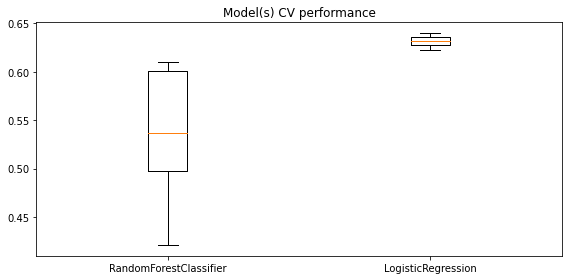

In [15]:
estimators_list = [clf_rf, clf_lrc]
plot_estimators_cvperf(estimators_list)

In [16]:
# Selecting the optimal model and Re-fiting with the whole training dataset:
estimators_cvperf = [pd.DataFrame(estimator.cv_results_)['mean_test_score'].max() for estimator in estimators_list]
clf_opt = estimators_list[np.argmax(estimators_cvperf)]
model = clf_opt.best_estimator_.fit(x_train_encoded, y_train)
model

c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=10, max_iter=700, solver='saga')

In [17]:
estimators_cvperf

[0.609749501035884, 0.6400210734752154]

# Submission

In [18]:
rating = model.predict(x_test_encoded)
df_submission = pd.DataFrame({"id": [i for i in range(x_test_encoded.shape[0])],
                              "rating": rating})
df_submission

,id,rating
0,0,4
1,1,3
2,2,3
3,3,2
4,4,1
...,...,...
39707,39707,1
39708,39708,5
39709,39709,2
39710,39710,4


In [19]:
submition_file = './submition_file.csv'
df_submission.to_csv(submition_file, index=False)

In [20]:
# !kaggle competitions list

In [21]:
# !kaggle competitions submit -c i2a2-nlp-2021-sentiment-analysis -f submition_file.csv -m "Model 04: NLP-based v2"